In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn import preprocessing
from wordfreq import word_frequency
import json

In [138]:
df = pd.read_excel("data/Data(初步处理异常单词).xlsx")
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
0,2022-01-07,202,slump,80630,1362,1,3,23,39,24,9,1
1,2022-01-08,203,crank,101503,1763,1,5,23,31,24,14,2
2,2022-01-09,204,gorge,91477,1913,1,3,13,27,30,22,4
3,2022-01-10,205,query,107134,2242,1,4,16,30,30,17,2
4,2022-01-11,206,drink,153880,3017,1,9,35,34,16,5,1


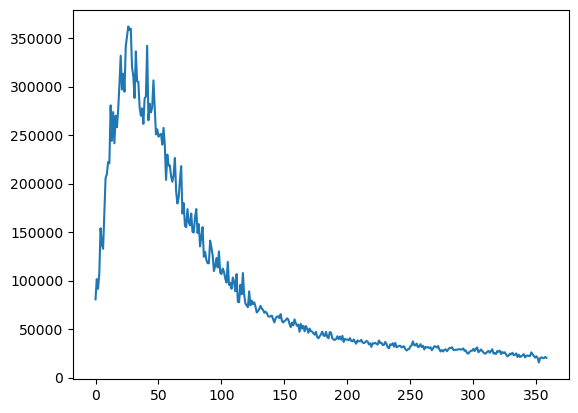

In [139]:
# 处理异常值
hard_counts = df['Number in hard mode'].values
all_counts = df['Number of  reported results'].values

err_id = np.where(all_counts < 5000)[0] # 观察到只有一个非常小的异常值
normal_id = np.delete(np.arange(len(all_counts)), err_id)
CS_all = CubicSpline(normal_id, all_counts[normal_id])
all_counts[err_id] = CS_all(err_id)

plt.plot(df['Number of  reported results'])

In [140]:
# 分布百分比归一化
df.iloc[:,5:12] = df.iloc[:,5:12].apply(lambda x: x / df.iloc[:,5:12].sum(axis=1) * 100)

# 求出词频
word_freq = df.Word.apply(lambda x: word_frequency(x, 'en'))
word_freq_score = np.log(word_freq)

# 重复字母
letter_dup = df['Word'].apply(lambda x: 5 - len(set(x)))
letter_dup[letter_dup>=1] = 1

In [141]:
# 字母频率
with open('data/allowed_words.txt') as fp:
    word_ls = fp.read().split('\n')
    word_ls.remove('')

letter_ls = []
for i in range(26):
    letter_ls.append(chr(ord('a') + i))

letter_freq = pd.Series(np.zeros(26), index=letter_ls)

for word in word_ls:
    freq = word_frequency(word, 'en')
    for i in range(5):
        if (ord(word[i]) >= ord('a')) and (ord(word[i]) <= ord('z')):
            letter_freq[word[i]] += 1 * freq

letter_freq = letter_freq / letter_freq.sum()

letter_score = np.log(letter_freq)

In [142]:
# 双字母组频率
with open('data/bigrams.json', encoding='utf-8') as fp:
    bigrams = json.load(fp)
bigrams_freq = pd.DataFrame(bigrams, columns=['bigrams', 'freq'])

bigrams_score = bigrams_freq.freq.copy()
bigrams_score[bigrams_score == 0] += 0.00000001
bigrams_score = np.log(bigrams_score)
bigrams_score.index = bigrams_freq.bigrams

In [143]:
def cal_bigram_freq_score(word):
    score = 0
    for i in range(4):
        score += bigrams_score[word[i:i+2]]
    return score

bigram_freq_score = np.zeros(df.shape[0])
for i in df.index:
    bigram_freq_score[i] = cal_bigram_freq_score(df.Word[i])

In [144]:
def cal_letter_freq_score(word):
    score = 0
    for j in range(5):
        score += letter_score[word[j]]
    return score

letter_freq_score = np.zeros(df.shape[0])
for i in df.index:
    letter_freq_score[i] = cal_letter_freq_score(df.Word[i])

In [145]:
def cnt_word_sim(word):
    cnt = 0
    for wword in word_ls:
        ccnt = 0
        for j in range(5):
            if word[j]==wword[j]:
                ccnt += 1
        if(ccnt==4):
            cnt += 1
    return cnt

word_sim = np.zeros(df.shape[0])
for i in df.index:
    word_sim[i] = cnt_word_sim(df.Word[i])

In [146]:
df['letter_freq_score'] = letter_freq_score
df['letter_dup'] = letter_dup
df['word_freq_score'] = word_freq_score
df['word_sim'] = word_sim
df['bigram_freq_score'] = bigram_freq_score

df.to_csv("data/data_preprocessed(新特征未归一化).csv", index=False)
df.head()

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),letter_freq_score,letter_dup,word_freq_score,word_sim,bigram_freq_score
0,2022-01-07,202,slump,80630,1362,1.000000,3.000000,23.000000,39.000000,24.000000,9.000000,1.000000,-16.868242,0,-12.986959,6.0,87.955966
1,2022-01-08,203,crank,101503,1763,1.000000,5.000000,23.000000,31.000000,24.000000,14.000000,2.000000,-15.836296,0,-12.411868,12.0,91.693273
2,2022-01-09,204,gorge,91477,1913,1.000000,3.000000,13.000000,27.000000,30.000000,22.000000,4.000000,-14.435656,1,-12.895228,5.0,91.211167
3,2022-01-10,205,query,107134,2242,1.000000,4.000000,16.000000,30.000000,30.000000,17.000000,2.000000,-18.830649,0,-12.340748,1.0,91.743784
4,2022-01-11,206,drink,153880,3017,0.990099,8.910891,34.653465,33.663366,15.841584,4.950495,0.990099,-15.917467,0,-9.441012,4.0,91.396963


In [147]:
min_max_scaler = preprocessing.MinMaxScaler()

new_df = df.copy()
new_df.iloc[:,12:] = min_max_scaler.fit_transform(new_df.iloc[:,12:])

new_df.to_csv("data/data_preprocessed(新特征归一化).csv", index=False)
new_df.head()

C:\Users\19828\AppData\Local\Temp\ipykernel_15780\2894688514.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_df.iloc[:,12:] = min_max_scaler.fit_transform(new_df.iloc[:,12:])


,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),letter_freq_score,letter_dup,word_freq_score,word_sim,bigram_freq_score
0,2022-01-07,202,slump,80630,1362,1.000000,3.000000,23.000000,39.000000,24.000000,9.000000,1.000000,0.381061,0.0,0.378564,0.260870,0.411294
1,2022-01-08,203,crank,101503,1763,1.000000,5.000000,23.000000,31.000000,24.000000,14.000000,2.000000,0.508926,0.0,0.430813,0.521739,0.594332
2,2022-01-09,204,gorge,91477,1913,1.000000,3.000000,13.000000,27.000000,30.000000,22.000000,4.000000,0.682474,1.0,0.386898,0.217391,0.570721
3,2022-01-10,205,query,107134,2242,1.000000,4.000000,16.000000,30.000000,30.000000,17.000000,2.000000,0.137907,0.0,0.437274,0.043478,0.596806
4,2022-01-11,206,drink,153880,3017,0.990099,8.910891,34.653465,33.663366,15.841584,4.950495,0.990099,0.498868,0.0,0.700724,0.173913,0.579820


In [148]:
min_max_scaler.transform([[cal_letter_freq_score('eerie'),
                            1,
                            np.log(word_frequency('eerie', 'en')),
                            cnt_word_sim('eerie'),
                            cal_bigrams_score('eerie'),
                            # 418 # Day
                            ]])

d:\CodingEnv\mambaforge\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[1.03075587, 1.        , 0.37240928, 0.08695652, 0.7425465 ]])

In [149]:
nnew_df = df.copy()
nnew_df['Day'] = nnew_df.index

mmin_max_scaler = preprocessing.MinMaxScaler()
nnew_df.iloc[:,12:] = mmin_max_scaler.fit_transform(nnew_df.iloc[:,12:])

nnew_df.to_csv('data/data_preprocessed(带天数归一化).csv', index=False)
nnew_df.head()

C:\Users\19828\AppData\Local\Temp\ipykernel_15780\3917468903.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  nnew_df.iloc[:,12:] = mmin_max_scaler.fit_transform(nnew_df.iloc[:,12:])


,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),letter_freq_score,letter_dup,word_freq_score,word_sim,bigram_freq_score,Day
0,2022-01-07,202,slump,80630,1362,1.000000,3.000000,23.000000,39.000000,24.000000,9.000000,1.000000,0.381061,0.0,0.378564,0.260870,0.411294,0.000000
1,2022-01-08,203,crank,101503,1763,1.000000,5.000000,23.000000,31.000000,24.000000,14.000000,2.000000,0.508926,0.0,0.430813,0.521739,0.594332,0.002793
2,2022-01-09,204,gorge,91477,1913,1.000000,3.000000,13.000000,27.000000,30.000000,22.000000,4.000000,0.682474,1.0,0.386898,0.217391,0.570721,0.005587
3,2022-01-10,205,query,107134,2242,1.000000,4.000000,16.000000,30.000000,30.000000,17.000000,2.000000,0.137907,0.0,0.437274,0.043478,0.596806,0.008380
4,2022-01-11,206,drink,153880,3017,0.990099,8.910891,34.653465,33.663366,15.841584,4.950495,0.990099,0.498868,0.0,0.700724,0.173913,0.579820,0.011173
